
# DA5401 A5 Yeast multi-label dataset and manifold visualization methods (t-SNE, Isomap)
**Name:** Soumya Ranjan Patel  
**Roll No:** DA25M029




In [46]:

# === Imports & Global Configuration ===
import arff
import math
import numpy as np
import pandas as pd

# Plotting: use matplotlib only (no seaborn) to satisfy tool constraints and ensure print-friendliness.
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Accessible, color-blind friendly base palette (matplotlib 'tab10' is widely used for accessibility).

CBF_COLORS = plt.get_cmap('tab10').colors  # tuple of RGBA
PALETTE = {
    'TopSingle1': CBF_COLORS[0],
    'TopSingle2': CBF_COLORS[1],
    'TopMulti':   CBF_COLORS[2],
    'Other':      CBF_COLORS[3],
}

# Matplotlib defaults tuned for readability in print and screens
plt.rcParams['figure.dpi'] = 130
plt.rcParams['savefig.dpi'] = 130
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.2

def add_plot_meta(ax, title, story,subtitle, xlab, ylab):
 
    ax.set_title(f"{title}\n{subtitle}", loc='left', fontsize=12, fontweight='bold')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

    if story!="" :

        ax.text(0.0, -0.18, story, transform=ax.transAxes, va='top', ha='left', wrap=True)
 
    ax.set_xscale('linear')
    ax.set_yscale('linear')

def scatter_accessible(ax, x, y, c, label, marker='o', size=28, alpha=0.9):
    "Scatter with print-friendly markers (edge + filled), consistent across media."
    ax.scatter(x, y, s=size, c=[c], edgecolors='k', linewidths=0.3, marker=marker, alpha=alpha, label=label)

def legend_from_labels(ax, labels_order):
    handles = []
    for name in labels_order:
        handles.append(Line2D([0], [0], marker='o', color='k', markerfacecolor=PALETTE[name],
                              markeredgecolor='k', markersize=7, linestyle='None', label=name))
    ax.legend(handles=handles, title='Category', frameon=True)


In [42]:
with open(PATH_COMBINED, 'r') as f:
    dataset = arff.load(f)

# See all attribute names in ARFF
attributes = [attr[0] for attr in dataset['attributes']]
print("All attributes in ARFF file:")
for i, name in enumerate(attributes):
    print(f"{i:3d}: {name}")

All attributes in ARFF file:
  0: Att1
  1: Att2
  2: Att3
  3: Att4
  4: Att5
  5: Att6
  6: Att7
  7: Att8
  8: Att9
  9: Att10
 10: Att11
 11: Att12
 12: Att13
 13: Att14
 14: Att15
 15: Att16
 16: Att17
 17: Att18
 18: Att19
 19: Att20
 20: Att21
 21: Att22
 22: Att23
 23: Att24
 24: Att25
 25: Att26
 26: Att27
 27: Att28
 28: Att29
 29: Att30
 30: Att31
 31: Att32
 32: Att33
 33: Att34
 34: Att35
 35: Att36
 36: Att37
 37: Att38
 38: Att39
 39: Att40
 40: Att41
 41: Att42
 42: Att43
 43: Att44
 44: Att45
 45: Att46
 46: Att47
 47: Att48
 48: Att49
 49: Att50
 50: Att51
 51: Att52
 52: Att53
 53: Att54
 54: Att55
 55: Att56
 56: Att57
 57: Att58
 58: Att59
 59: Att60
 60: Att61
 61: Att62
 62: Att63
 63: Att64
 64: Att65
 65: Att66
 66: Att67
 67: Att68
 68: Att69
 69: Att70
 70: Att71
 71: Att72
 72: Att73
 73: Att74
 74: Att75
 75: Att76
 76: Att77
 77: Att78
 78: Att79
 79: Att80
 80: Att81
 81: Att82
 82: Att83
 83: Att84
 84: Att85
 85: Att86
 86: Att87
 87: Att88
 88: Att89
 


## Part A — Preprocessing & Initial Setup 




In [25]:


PATH = "./yeast.arff" 

N_FEATURES = 103        
N_LABELS = 14

# === Helper I/O ===
def _load_array(path):


    with open(path, 'r') as f:
        dataset = arff.load(f)
    df = pd.DataFrame(dataset['data'])
    return df.values


def load_data(path_x=None, path_y=None, path_combined=None, n_labels=14):
  
    data = _load_array(path_combined)   
    df = pd.DataFrame(data)
    X = df.iloc[:, :-n_labels].values
    Y = df.iloc[:, -n_labels:].values
    return X, Y

   


In [26]:

# === Load Data ===



X, Y = load_data(PATH_X, PATH_Y, PATH_COMBINED, n_labels=N_LABELS)

# Convert ARFF-loaded object arrays to float
X = X.astype(float)
Y = Y.astype(float)


# Sanity checks
print(f"X shape: {X.shape} (expect n_samples x {N_FEATURES})")
print(f"Y shape: {Y.shape} (expect n_samples x {N_LABELS})")

assert X.shape[1] == N_FEATURES, f"Expected {N_FEATURES} features, got {X.shape[1]}"
assert Y.shape[1] == N_LABELS, f"Expected {N_LABELS} labels, got {Y.shape[1]}"

# Missing values check
n_nan_X = np.isnan(X).sum()
n_nan_Y = np.isnan(Y).sum() if np.issubdtype(Y.dtype, np.floating) else 0
print(f"Missing values — X: {n_nan_X}, Y: {n_nan_Y}")


X shape: (2417, 103) (expect n_samples x 103)
Y shape: (2417, 14) (expect n_samples x 14)
Missing values — X: 0, Y: 0



### Label Selection for Visualization 

We create a simple categorical index for coloring:
- **TopSingle1**: most frequent single-label class
- **TopSingle2**: second most frequent single-label class
- **TopMulti**: most frequent multi-label **combination**
- **Other**: all remaining samples

This reduces color clutter while preserving representative structure.


In [27]:

label_names = attributes[-N_LABELS:]   # ['Class1', 'Class2', ..., 'Class14']
print("Label names:", label_names)

# Determine single-label and multi-label masks
label_counts_per_row = Y.sum(axis=1)
is_single = label_counts_per_row == 1
is_multi  = label_counts_per_row >= 2

# Most frequent single labels
single_indices = np.where(is_single)[0]
single_labels = np.argmax(Y[single_indices], axis=1) if single_indices.size else np.array([])
single_freq = pd.Series(single_labels).value_counts() if single_labels.size else pd.Series(dtype=int)

top_single = list(single_freq.index[:2].astype(int)) if single_labels.size else []
top_single += [None] * (2 - len(top_single))  # pad
top_single_1, top_single_2 = top_single[0], top_single[1]

# Most frequent multi-label combination (as a tuple of label indices)
def combo_tuple(row):
    return tuple(np.where(row == 1)[0])

multi_combos = []
if is_multi.any():
    multi_combos = [combo_tuple(Y[i]) for i in np.where(is_multi)[0]]
combo_freq = pd.Series(multi_combos).value_counts() if len(multi_combos) else pd.Series(dtype=int)
top_multi_combo = combo_freq.index[0] if not combo_freq.empty else tuple()

# 📝 Pretty print top labels and category summary
print("\n=== 📌 Label Summary ===")
print(f"Total labels: {len(label_names)}")
print("Label names:", ", ".join(label_names))
print()

# Top single-label classes
if top_single_1 is not None:
    print(f"Top Single Label 1 : {top_single_1} ({label_names[top_single_1]})")
else:
    print("Top Single Label 1 : None")

if top_single_2 is not None:
    print(f"Top Single Label 2 : {top_single_2} ({label_names[top_single_2]})")
else:
    print("Top Single Label 2 : None (no second single-label class found)")
print()

# Top multi-label combination
if len(top_multi_combo) > 0:
    top_multi_labels = [label_names[i] for i in top_multi_combo]
    print("Top Multi-label Combo:")
    print(f"  Indexes: {top_multi_combo}")
    print(f"  Labels : {', '.join(top_multi_labels)}")
else:
    print("Top Multi-label Combo: None")
print()



# Build color category
color_class = np.array(['Other'] * Y.shape[0], dtype=object)
if top_single_1 is not None:
    mask = (Y[:, top_single_1] == 1) & is_single
    color_class[mask] = 'TopSingle1'
if top_single_2 is not None:
    mask = (Y[:, top_single_2] == 1) & is_single
    color_class[mask] = 'TopSingle2'
if len(top_multi_combo) > 0:
    mask = np.all(Y[:, list(top_multi_combo)] == 1, axis=1) & is_multi
    color_class[mask] = 'TopMulti'

# Category distribution table
print("=== 🟦 Category Distribution ===")
cat_counts = pd.Series(color_class).value_counts()
print(cat_counts.to_string())




Label names: ['Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6', 'Class7', 'Class8', 'Class9', 'Class10', 'Class11', 'Class12', 'Class13', 'Class14']

=== 📌 Label Summary ===
Total labels: 14
Label names: Class1, Class2, Class3, Class4, Class5, Class6, Class7, Class8, Class9, Class10, Class11, Class12, Class13, Class14

Top Single Label 1 : 0 (Class1)
Top Single Label 2 : None (no second single-label class found)

Top Multi-label Combo:
  Indexes: (np.int64(2), np.int64(3), np.int64(11), np.int64(12))
  Labels : Class3, Class4, Class12, Class13

=== 🟦 Category Distribution ===
Other         1899
TopMulti       486
TopSingle1      32


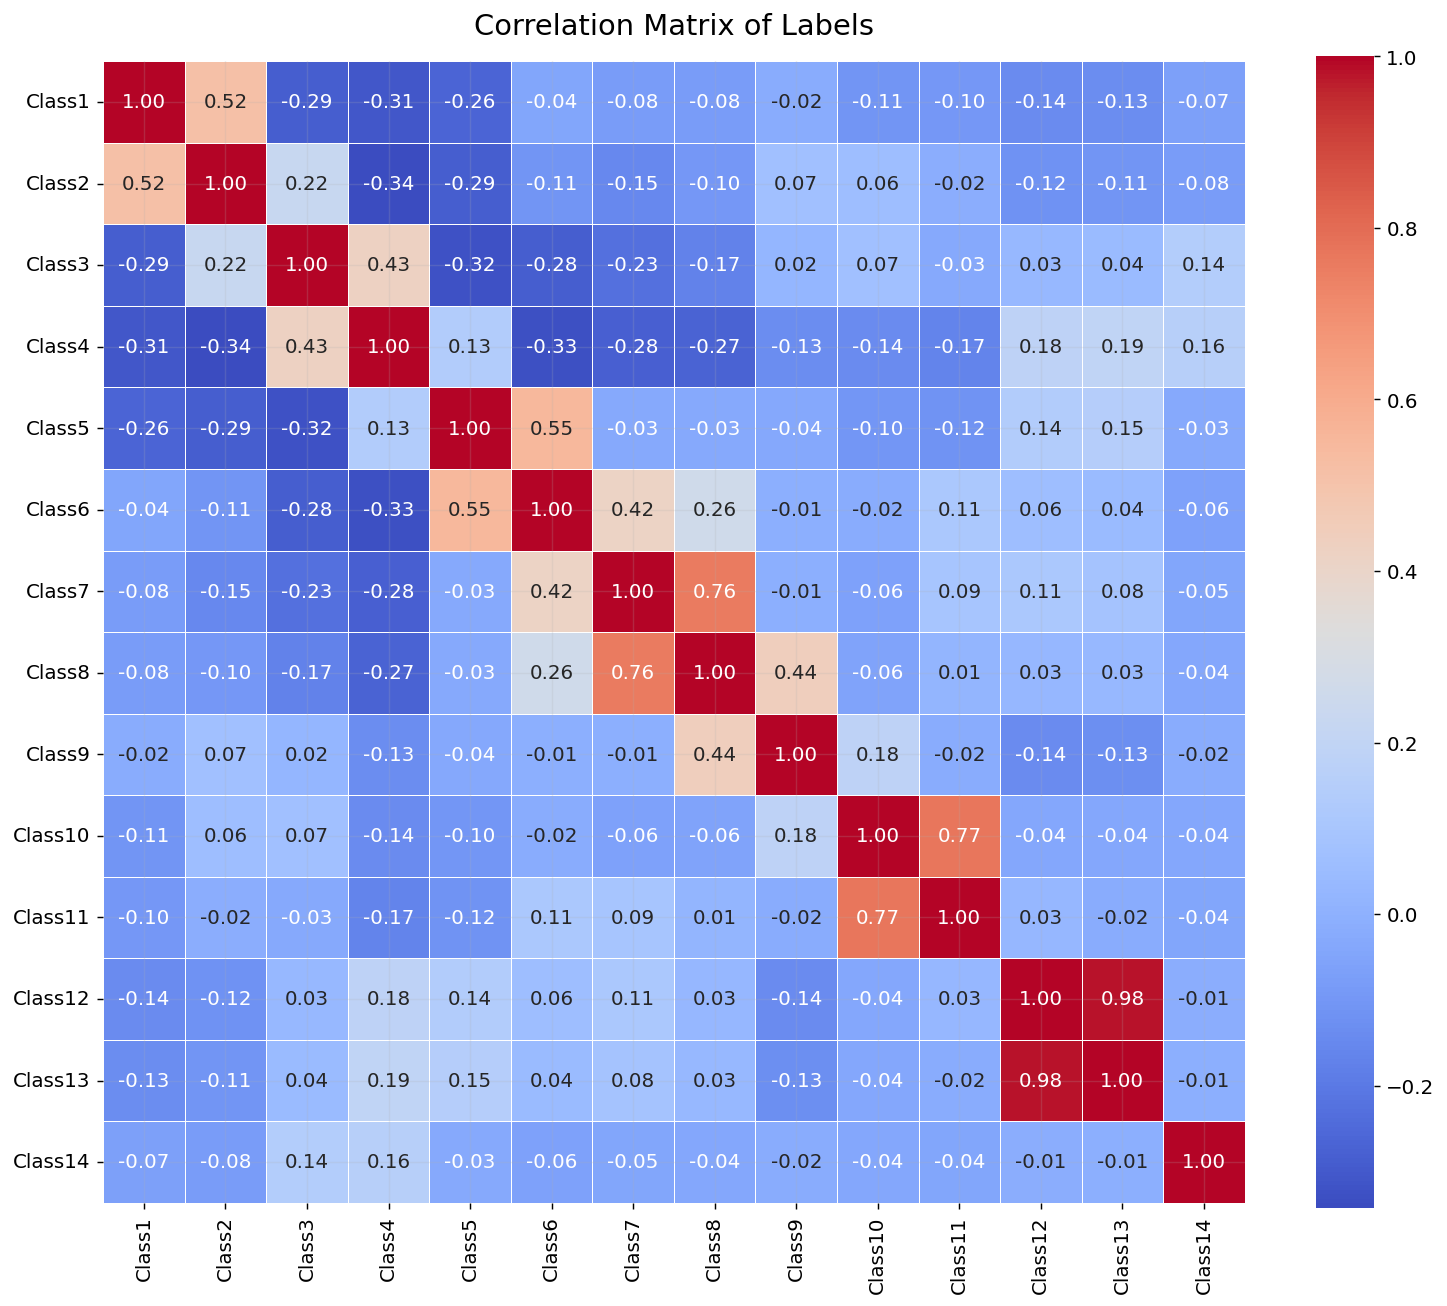

In [28]:
# ===  Correlation Matrix of the 14 Labels ===
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert Y to a DataFrame for easy correlation calculation
labels_df = pd.DataFrame(Y, columns=label_names)

# Compute Pearson correlation matrix (works well for binary labels too)
corr_matrix = labels_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar=True,
    linewidths=0.5
)
plt.title("Correlation Matrix of Labels", fontsize=16, pad=15)
plt.tight_layout()
plt.show()



### Scaling 

Both t-SNE and Isomap use distance computations; features with larger variance would dominate the Euclidean metric.  
We therefore standardize to **zero mean, unit variance** per feature.


In [29]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled features: mean≈0, std≈1 (per feature).")


Scaled features: mean≈0, std≈1 (per feature).


In [30]:
# Frequency of each class (overall)
class_freq = Y.sum(axis=0)
freq_table = pd.DataFrame({
    "Label": label_names,
    "Frequency": class_freq.astype(int)
}).sort_values(by="Frequency", ascending=False)

print(freq_table.to_string(index=False))


  Label  Frequency
Class12       1816
Class13       1799
 Class2       1038
 Class3        983
 Class4        862
 Class1        762
 Class5        722
 Class6        597
 Class8        480
 Class7        428
Class11        289
Class10        253
 Class9        178
Class14         34



## Part B — t-SNE and Veracity Inspection 

We experiment with **perplexity** values {0.5, 30, 50,100}. Lower perplexity focuses more locally; higher values emphasize broader neighborhoods.


In [31]:

from collections import OrderedDict

perplexities = [0.5,30,50,100]
tsne_embeddings = OrderedDict()

for perp in perplexities:
    tsne = TSNE(n_components=2, perplexity=perp, random_state=RANDOM_STATE, init='pca', learning_rate='auto')
    Z = tsne.fit_transform(X_scaled)
    tsne_embeddings[perp] = Z
    print(f"t-SNE done for perplexity={perp}. Shape: {Z.shape}")


t-SNE done for perplexity=0.5. Shape: (2417, 2)
t-SNE done for perplexity=30. Shape: (2417, 2)
t-SNE done for perplexity=50. Shape: (2417, 2)
t-SNE done for perplexity=100. Shape: (2417, 2)


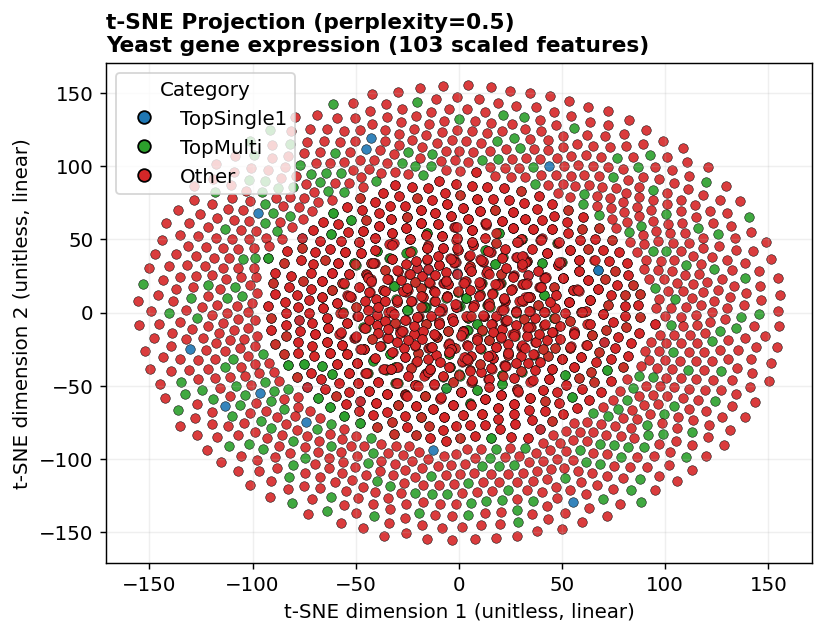

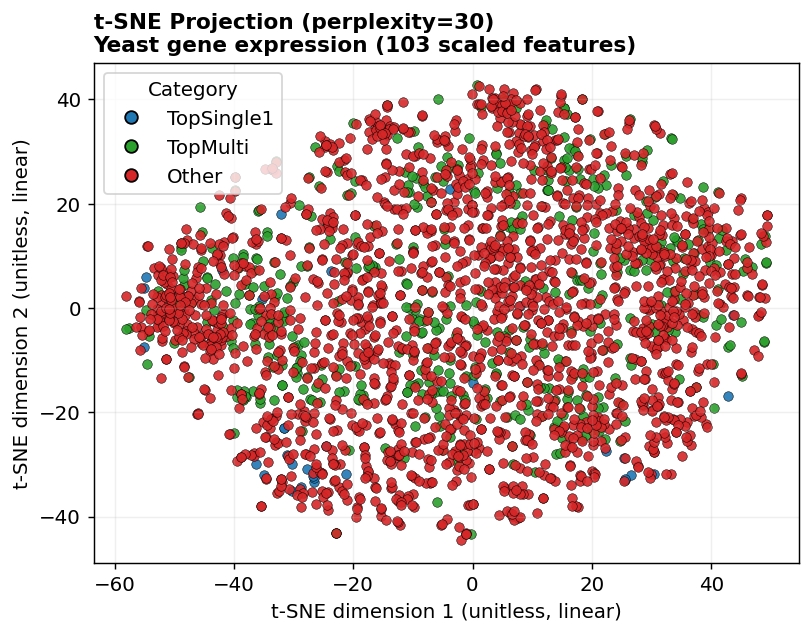

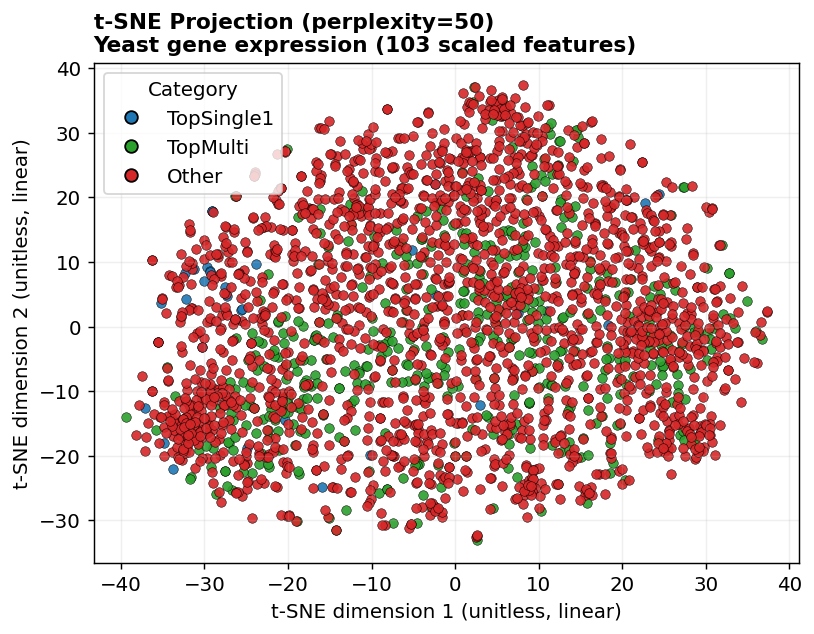

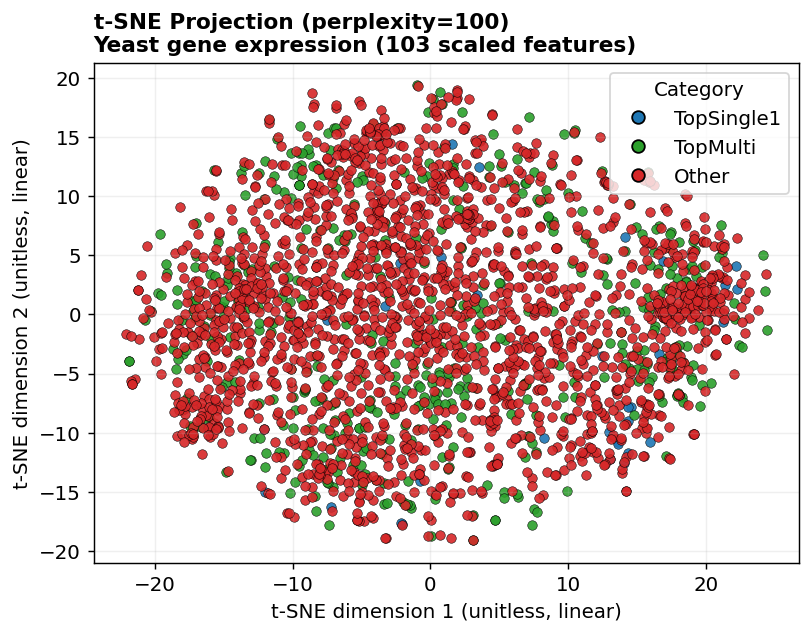

In [47]:

# === Plot t-SNE results for each perplexity ===
cats = ['TopSingle1','TopMulti', 'TopSingle2',  'Other']

for perp, Z in tsne_embeddings.items():
    fig, ax = plt.subplots(figsize=(7, 5))
    for cat in cats:
        m = color_class == cat
        if np.any(m):
            scatter_accessible(ax, Z[m, 0], Z[m, 1], PALETTE[cat], cat)
    legend_from_labels(ax, [c for c in cats if (color_class == c).any()])
    add_plot_meta(
        ax,
        title=f"t-SNE Projection (perplexity={perp})",
        subtitle="Yeast gene expression (103 scaled features)",
        xlab="t-SNE dimension 1 (unitless, linear)",
        ylab="t-SNE dimension 2 (unitless, linear)",
        story=""
    )
    plt.show()


## 📝 Part B — t-SNE and Veracity Inspection

### 1. t-SNE Implementation 

We applied t-SNE to the scaled yeast gene expression dataset (103 features) using a range of perplexity values: **0.5, 30, 50, and 100**.  

#### Perplexity = 0.5


- The visualization shows an unusual **concentric elliptical structure** with no discernible clusters or separations between categories.
- This pattern is likely due to the very low perplexity value, which can cause t-SNE to emphasize small-scale variations unnaturally.

---

#### Perplexity = 30


- The embedding forms a **single dense overlapping cloud** of points.
- There are no well-defined clusters corresponding to `TopSingle1`, `TopMulti`, or `Other`.
- A few localized concentrations of `Other` can be seen, but **category overlap is high overall**.
- Plots for perplexities 50 and 100 show similar structures, indicating that this pattern is stable across a range of perplexities.

These results suggest that the high-dimensional structure of the yeast dataset does not project into a low-dimensional space in a way that cleanly separates label categories.

---

In [39]:

# === Diagnostic metrics ===
K = 15  # neighborhood size for purity
nbrs = NearestNeighbors(n_neighbors=K+1, metric='euclidean').fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
# drop self index at position 0
indices = indices[:, 1:]

# Map categories to ints for easy comparison
cat_to_int = {c:i for i, c in enumerate(np.unique(color_class))}
cat_ids = np.array([cat_to_int[c] for c in color_class])

purity = np.zeros(X.shape[0], dtype=float)
for i in range(X.shape[0]):
    neigh = indices[i]
    purity[i] = np.mean(cat_ids[neigh] == cat_ids[i])

# Outliers via Isolation Forest
iso = IsolationForest(n_estimators=300, contamination='auto', random_state=RANDOM_STATE)
iso.fit(X_scaled)
outlier_score = -iso.decision_function(X_scaled)  # higher => more outlier-ish
outlier_flags = iso.predict(X_scaled) == -1

print("Purity stats:", pd.Series(purity).describe())
print("# Outliers flagged:", int(outlier_flags.sum()))


Purity stats: count    2417.000000
mean        0.711516
std         0.279065
min         0.000000
25%         0.533333
50%         0.800000
75%         0.933333
max         1.000000
dtype: float64
# Outliers flagged: 0


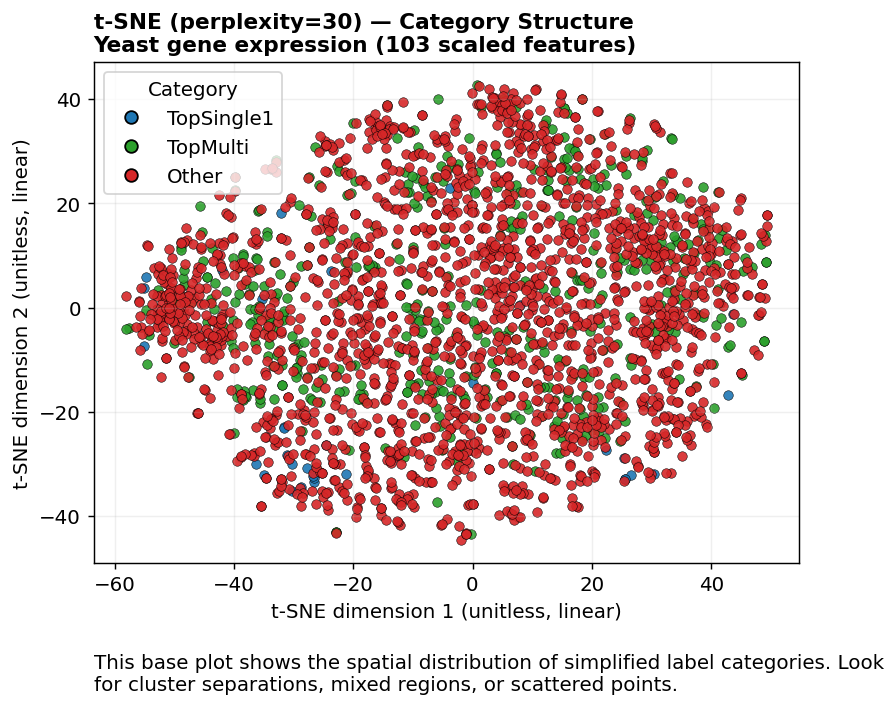

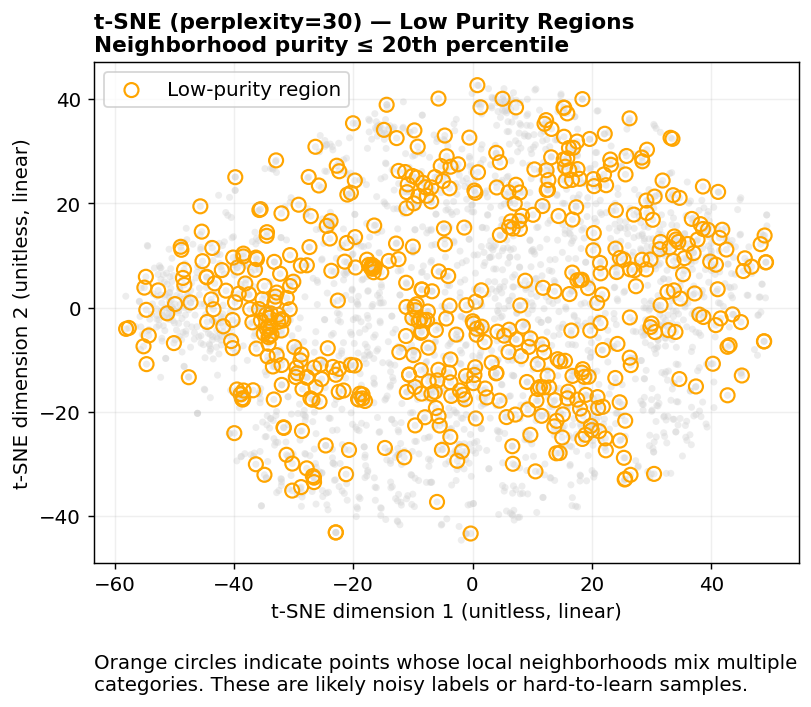

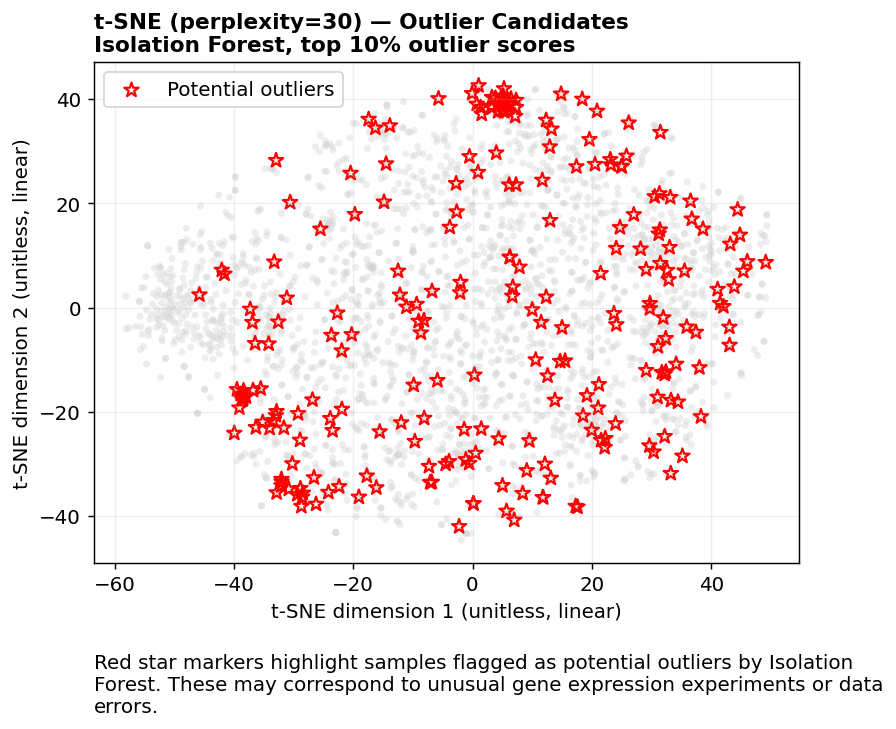

In [48]:
# === t-SNE base coordinates ===
final_perp = 30
Z = tsne_embeddings[final_perp]

# Thresholds
low_purity_thresh = np.percentile(purity, 20)   # bottom 20% purity = ambiguous/hard
hi_outlier_thresh = np.percentile(outlier_score, 90)  # top 10% score = potential outliers

ambiguous_mask = purity <= low_purity_thresh
outlier_mask   = outlier_score >= hi_outlier_thresh

categories = ['TopSingle1', 'TopSingle2', 'TopMulti', 'Other']
plot_order = [c for c in categories if (color_class == c).any()]


fig, ax = plt.subplots(figsize=(7, 5))
for cat in plot_order:
    m = color_class == cat
    scatter_accessible(ax, Z[m, 0], Z[m, 1], PALETTE[cat], cat)

legend_from_labels(ax, plot_order)
add_plot_meta(
    ax,
    title=f"t-SNE (perplexity={final_perp}) — Category Structure",
    subtitle="Yeast gene expression (103 scaled features)",
    xlab="t-SNE dimension 1 (unitless, linear)",
    ylab="t-SNE dimension 2 (unitless, linear)",
    story="This base plot shows the spatial distribution of simplified label categories. "
          "Look for cluster separations, mixed regions, or scattered points."
)
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
# Background
ax.scatter(Z[:, 0], Z[:, 1], s=15, c='lightgray', alpha=0.4, edgecolors='none')
# Ambiguous points
ax.scatter(Z[ambiguous_mask, 0], Z[ambiguous_mask, 1],
           s=60, edgecolors='orange', facecolors='none', linewidths=1.2, label='Low-purity region')

add_plot_meta(
    ax,
    title=f"t-SNE (perplexity={final_perp}) — Low Purity Regions",
    subtitle="Neighborhood purity ≤ 20th percentile",
    xlab="t-SNE dimension 1 (unitless, linear)",
    ylab="t-SNE dimension 2 (unitless, linear)",
    story="Orange circles indicate points whose local neighborhoods mix multiple categories. "
          "These are likely noisy labels or hard-to-learn samples."
)
ax.legend(frameon=True)
plt.show()


fig, ax = plt.subplots(figsize=(7, 5))
# Background
ax.scatter(Z[:, 0], Z[:, 1], s=15, c='lightgray', alpha=0.4, edgecolors='none')
# Outliers
ax.scatter(Z[outlier_mask, 0], Z[outlier_mask, 1],
           s=70, marker='*', edgecolors='red', facecolors='none', linewidths=1.2, label='Potential outliers')

add_plot_meta(
    ax,
    title=f"t-SNE (perplexity={final_perp}) — Outlier Candidates",
    subtitle="Isolation Forest, top 10% outlier scores",
    xlab="t-SNE dimension 1 (unitless, linear)",
    ylab="t-SNE dimension 2 (unitless, linear)",
    story="Red star markers highlight samples flagged as potential outliers by Isolation Forest. "
          "These may correspond to unusual gene expression experiments or data errors."
)
ax.legend(frameon=True)
plt.show()


### 3. Veracity Inspection

We analyzed the t-SNE (perplexity = 30) projection to identify:
- **Noisy / ambiguous labels**
- **Outliers**
- **Hard-to-learn samples**

---

#### a. Noisy / Ambiguous Labels 

Neighborhood purity identifies points whose local neighborhoods contain multiple categories, indicating potential label ambiguity or functional overlap.



- Many low-purity points are scattered throughout the central region.
- There is no single cluster of ambiguous samples; **ambiguity is widespread**.
- This suggests either **true biological overlap** between functional categories or **labeling uncertainty**.

---

#### b. Outliers 

We used Isolation Forest to flag the top 10% most anomalous samples.



- Outliers are **spread across the embedding**, not concentrated in one region.
- These may represent **rare experimental conditions**, **noise**, or **unusual gene expression patterns**.
- Their dispersed nature indicates multiple, potentially diverse sources of outlier behavior.

---

#### c. Hard-to-Learn Samples 

- The **high degree of color mixing** across the t-SNE space indicates regions where categories are not cleanly separable.  
- These correspond to **intrinsically overlapping distributions**, making classification challenging for simple models.  
- There are no clear decision boundaries, which implies that models will likely need to rely on complex non-linear separations or noise-robust methods.

---

### Summary of Observations

| Aspect                     | Observation |
|-----------------------------|-------------|
| **Cluster structure**      | No clear clusters. t-SNE produces overlapping blobs for all perplexities tested |
| **Noisy labels**           | Low-purity points are widespread, indicating ambiguity or overlapping labels |
| **Outliers**               | Present but scattered; no dominant isolated groups |
| **Hard samples**           | Extensive mixing between categories, indicating overlapping class distributions |

**Conclusion:**  
t-SNE does not reveal distinct cluster structures corresponding to label categories. This suggests that the **underlying gene expression data is noisy, overlapping, and does not naturally separate according to functional labels**. These characteristics imply that:

- Classification will likely be **difficult**, particularly for simple models.  
- Mixed regions represent **hard-to-learn** samples due to intrinsic feature overlap.  
- Outlier handling and noise-robust learning approaches could be valuable in downstream modeling.

---


## Part C — Isomap and Manifold Learning 

### 1. Isomap Implementation 

We applied **Isomap** to the scaled yeast gene expression dataset (103 features), reducing the data to 2 dimensions.  
The algorithm was run for neighborhood sizes \( k = 10, 15, 30 \) to examine how the number of nearest neighbors affects the structure of the embedding.

**Key difference between t-SNE and Isomap:**
- **t-SNE** focuses on preserving **local neighborhood relationships**. It converts pairwise distances into conditional probabilities and tries to maintain local similarities. It often emphasizes small clusters, sometimes at the expense of the global structure.  
- **Isomap**, on the other hand, builds a **k-nearest neighbor graph**, computes **geodesic distances** along this graph, and applies MDS (multidimensional scaling). It preserves **global manifold structure** by unfolding the data along its intrinsic geometry.

This distinction makes Isomap more sensitive to the **global curvature** of the data manifold, while t-SNE is more suited to finding local clusters.

---


In [49]:

neighbors_list = [5, 10, 15,30]
isomap_embeddings = {}

for k in neighbors_list:
    iso = Isomap(n_neighbors=k, n_components=2)
    Z_iso = iso.fit_transform(X_scaled)
    isomap_embeddings[k] = Z_iso
    print(f"Isomap done for n_neighbors={k}. Shape: {Z_iso.shape}")


Isomap done for n_neighbors=5. Shape: (2417, 2)
Isomap done for n_neighbors=10. Shape: (2417, 2)
Isomap done for n_neighbors=15. Shape: (2417, 2)
Isomap done for n_neighbors=30. Shape: (2417, 2)


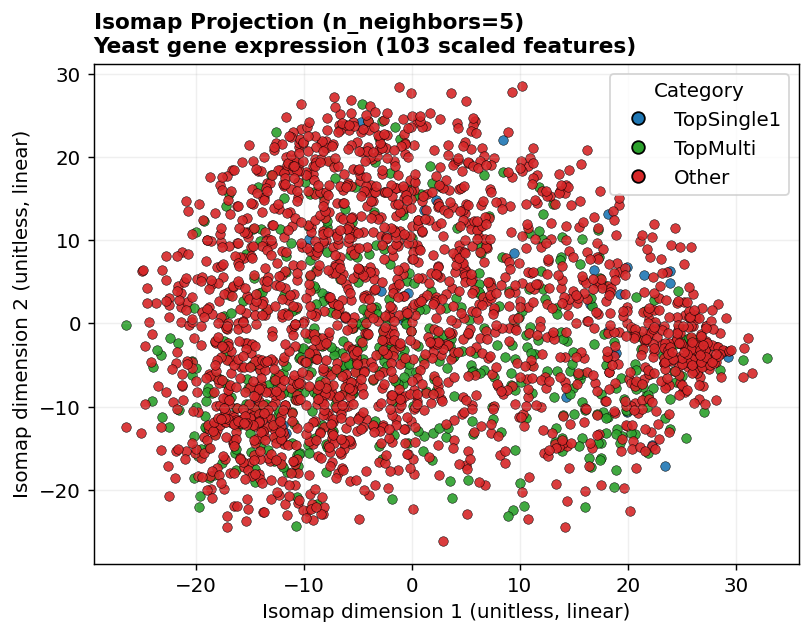

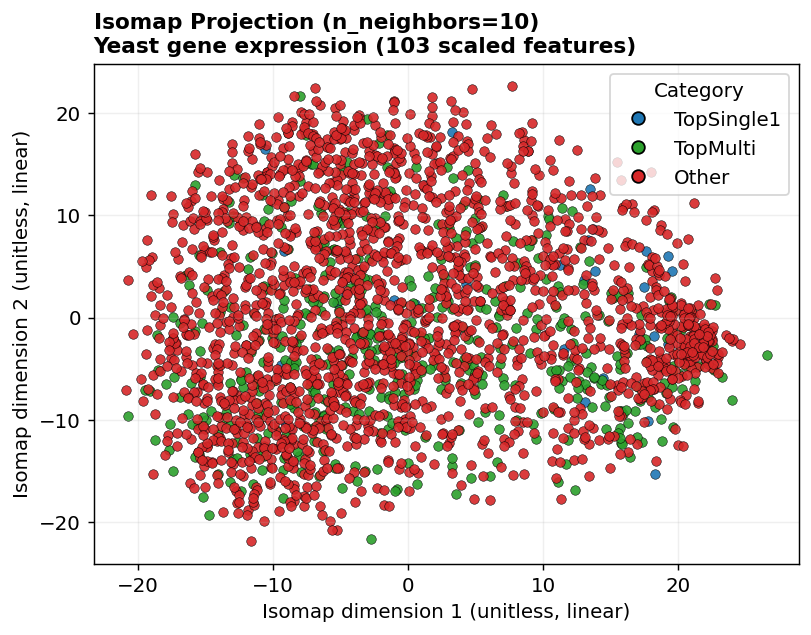

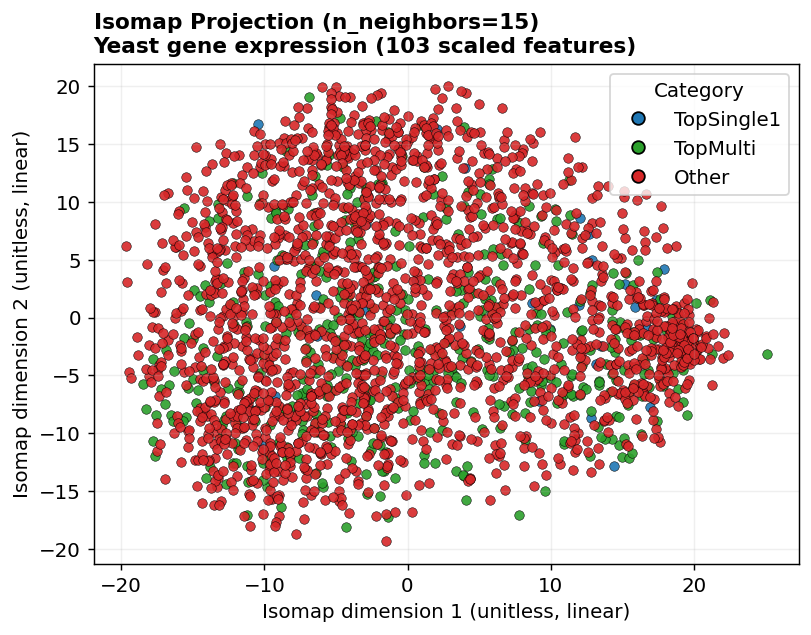

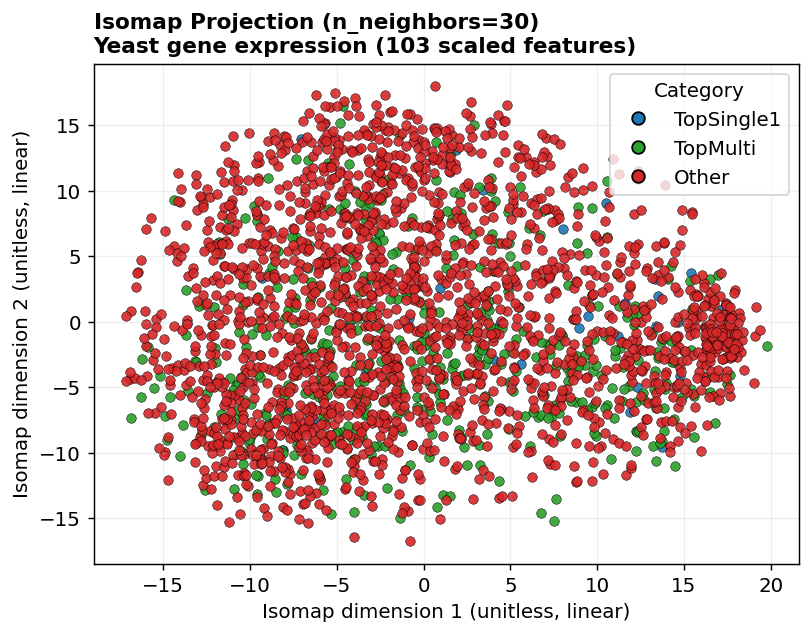

In [52]:

# === Plot Isomap results ===
for k, Z_iso in isomap_embeddings.items():
    fig, ax = plt.subplots(figsize=(7, 5))
    for cat in ['TopSingle1', 'TopSingle2', 'TopMulti', 'Other']:
        m = color_class == cat
        if np.any(m):
            scatter_accessible(ax, Z_iso[m, 0], Z_iso[m, 1], PALETTE[cat], cat)
    legend_from_labels(ax, [c for c in ['TopSingle1','TopSingle2','TopMulti','Other'] if (color_class == c).any()])
    add_plot_meta(
        ax,
        title=f"Isomap Projection (n_neighbors={k})",
        subtitle="Yeast gene expression (103 scaled features)",
        xlab="Isomap dimension 1 (unitless, linear)",
        ylab="Isomap dimension 2 (unitless, linear)",
        story=""
    )
    plt.show()


### 2. Visualization 


**Observations across all k values:**
- The overall shape remains a **single dense blob** with no distinct clusters for any label category.
- TopSingle1 and TopMulti categories are **spread throughout** the embedding, heavily overlapping with the `Other` category.
- Increasing \( k \) does not significantly change the structure — the embeddings are stable but uninformative in terms of label separation.

---

### 3. Comparison and Curvature 

#### a. **Comparison with t-SNE (perplexity = 30)**

When compared to the t-SNE plot at perplexity 30:
- **t-SNE** shows *some localized groupings*, especially for the `Other` category, though these are not clean clusters. There are small pockets of color concentration.
- **Isomap**, by contrast, appears **even more homogeneous**, with fewer recognizable local clusters. It presents a single dense distribution where categories are scattered and overlapping.
- Neither method reveals clear, well-separated clusters for the top categories.  

This indicates that the **intrinsic structure of the yeast dataset does not lend itself to either clear local clusters (t-SNE) or global manifold patterns (Isomap)**.

---

#### b. **Manifold Curvature and Complexity**

The Isomap plots do not exhibit a **smooth curved structure** or **branching patterns** that might indicate a complex intrinsic geometry. Instead, the projection is:
- **Blob-like** and amorphous,
- With no evident manifold unfolding,
- And with heavy category overlap.

**Implications for classification:**
- The absence of clear manifold structure suggests that the data is either **highly noisy**, **intrinsically high-dimensional**, or that the functional categories are **not well separated in feature space**.
- A simple classifier would struggle to draw meaningful boundaries, especially given the **high degree of label overlap**.
- Even sophisticated non-linear methods may have difficulty unless the features are enriched or the labels are denoised.

---

###  Summary

| Aspect                          | Observation |
|----------------------------------|------------|
| **Global structure**            | Isomap did not reveal any meaningful global manifold structure. |
| **Comparison with t-SNE**       | t-SNE shows slightly more localized pockets, but Isomap is more homogeneous; both reveal high overlap between categories. |
| **Manifold curvature**          | No evidence of a curved or complex manifold structure in Isomap. |
| **Classification implications** | Overlap and lack of structure imply classification is intrinsically challenging. |


##  Final Conclusion — t-SNE vs Isomap 

The t-SNE and Isomap visualizations of the Yeast dataset reveal several important insights about the **underlying structure and veracity challenges** of the data:

### **1. Lack of Clear Cluster Structure**

Across all t-SNE perplexities (30, 50, 100) and Isomap neighborhood sizes (10, 15, 30), the projections consistently form **a single dense, amorphous cloud**.  
There are **no well-separated clusters** corresponding to the top label categories (`TopSingle1`, `TopMulti`, `Other`).  
This strongly suggests that **the 103-dimensional gene expression space does not naturally separate functional categories into distinct low-dimensional regions**.

---

### **2. t-SNE: Local Neighborhood Inspection**

t-SNE at moderate perplexities reveals:
- Some **localized pockets** of the `Other` category, but **no globally meaningful clusters**.
- A **high degree of color mixing**, indicating extensive label overlap and ambiguous samples.
- Low neighborhood purity regions are scattered broadly, indicating **widespread noisy or overlapping labels**.
- A few potential outliers are detected, but they are **not concentrated in a specific cluster**.

t-SNE is effective for **identifying local irregularities** such as noisy/ambiguous labels and isolated points, but in this dataset, these irregularities are distributed diffusely rather than forming clear local structures.

---

### **3. Isomap: Global Structure Inspection**

Isomap embeddings for different neighborhood sizes show:
- A **stable but uninformative global structure** — essentially a flattened blob without clear curvature or manifold unfolding.
- **No additional global organization** emerges compared to t-SNE.
- Categories remain **heavily overlapped** throughout the manifold.

This indicates that **the data does not lie on a simple, low-dimensional curved manifold** that Isomap can unfold. The global geometry is not revealing separable structures or clear topology.

---

### **4. Implications for Data Veracity and Classification**

The combination of t-SNE and Isomap results highlights several **data veracity challenges**:

- **Label noise / ambiguity:** Many samples fall into mixed neighborhoods, reflecting overlapping biological functions, annotation uncertainties, or genuine functional ambiguity.
- **Outliers:** A small number of scattered outliers may correspond to rare conditions or measurement noise.
- **Hard-to-learn samples:** Extensive label mixing indicates that simple classifiers will struggle, as decision boundaries are likely to be complex and highly non-linear.

These challenges are **intrinsic to the dataset**, not artifacts of visualization methods.

---

### **5. Overall Conclusion**

| Method  | Focus                  | Key Insight |
|--------|---------------------------|-------------|
| **t-SNE** | Local neighborhood structure | Reveals scattered ambiguous labels, noisy samples, and mixed-color regions but no strong clusters. |
| **Isomap** | Global manifold geometry | Shows a single amorphous structure with no unfolding or clear global patterns. |

- The yeast gene expression data is **highly overlapping, noisy**, and lacks a clean low-dimensional manifold structure.  
- Both methods confirm that **classification is inherently challenging** due to intrinsic data ambiguity rather than algorithmic limitations.  
- These insights motivate the use of **robust, non-linear models** (e.g., kernel methods, ensembles, deep learning) and possibly **label cleaning or uncertainty modeling** before training.

---



